In [146]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab12.ok')

Assignment: lab12
OK, version v1.13.11



# Lab 12: Scalable Data Processing Using Ray
  <img src="https://i.imgur.com/6DHvEJil.jpg" alt="ray_logo" align="right" width="400"/>


**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## Due Date

This assignment is due at 11:59pm Tuesday, August 6th.

In this lab, you will learn the basics of Ray and use it to speed up the process of finding word frequency in texts.

**Collaborators:** *write names here*

## This Assignment
Although you've learned powerful techniques for processing data, most of the problems you've worked on involved small datasets that a single machine can quickly process. Data science in practical settings often involves processing hundreds of gigabytes, terabytes, and even petabytes of data. 

These data sets are too large for a single computer to process quickly, so data scientists often *scale up* their programs to *clusters*, many computers working together to run a program. On a smaller scale, we can also parallelize programs across processor cores in a single computer.

For this lab, we will use [Ray](https://ray.readthedocs.io/en/latest/), a system for parallel and distributed Python (developed at Berkeley), which can parallelize programs across the cores of a single computer as well as a cluster. While your code for this homework will only parallelize across the cores of a single JupyterHub computer, you could run it on a cluster as well without any changes.

Throughout this assignment, you may find it helpful to refer to the following:
- [Ray documentation](https://ray.readthedocs.io/en/latest/)
- [Ray codebase](https://github.com/ray-project/ray)

### Note
- This assignment will have no hidden tests and no written parts. If you pass all the tests, you are good to go!
- This assignment will **consist of a lot of reading rather than coding**. If you are confused on anything, feel free to ask on Piazza.

## 1: Learning the Ray API

Let's start by digging into the Ray API and familiarize ourselves with some of its functionalities. Again, please reference the [Ray documentation](https://ray.readthedocs.io/en/latest/) and [Ray codebase](https://github.com/ray-project/ray) if you have any questions.

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import time
import urllib.request

from utils import timeit

import ray
from colorama import Fore

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

To start Ray, we will first import ray and call `ray.init`. We will use 8 cpus. 

You should see something like the following, ray is telling us information about our tiny compute cluster:

<img src="https://i.imgur.com/JOOtGFr.png" alt="ray_init" width="600"/>


In [148]:
ray.init(
    num_cpus=8, # We will be using 8 workers
    include_webui=False,  
    plasma_directory='/tmp', # The object store is mounted to local file system
    ignore_reinit_error=True,
    object_store_memory=int(2*1e9), 
)



2019-08-06 12:57:05,009	ERROR worker.py:1412 -- Calling ray.init() again after it has already been called.


For now, let's start with the basics. With Ray, Python objects can live either within process or within Ray's shared memory. Ray's shared memory is responsible for transfering objects among the current process and the workers, such that data is shared across different functions that might run in parallel.

`ray.put(x)` copies an object `x` from the current process to Ray's shared object store and returns an ID for that object.

`ray.get(x_id)` returns the object determined by the object's ID `x_id` from Ray's shared object store.

You can think of this as sending python object to a in-memory database so it can be accessed by other peer python processes. 

If that seems a little confusing, that's ok! The following example should clear it up. The most important thing is to understand `ObjectID`s and `ray.get`:

In [149]:
# x is a python object within this process.
x = 42  
print(f"""
    x's type is {Fore.BLUE} {type(x)} {Fore.RESET}
    and its value is {Fore.BLUE} {x} {Fore.RESET}
""")


    x's type is  <class 'int'> 
    and its value is  42 



Now we copy x to Ray's object store. This lets you share x among different Ray worker processes.

In [150]:
# Copy x to Ray's object store. 
# This lets you share x among different Ray worker processes.
x_id = ray.put(x)  
print(f"""
    x_id's type is {Fore.BLUE} {type(x_id)} {Fore.RESET}
    and its value is {Fore.BLUE} {x_id} {Fore.RESET}
""")


    x_id's type is  <class 'ray._raylet.ObjectID'> 
    and its value is  ObjectID(27fbffff08cd6b15ddfa9c36a279d0f5fa309853) 



We can retrieve the object using x_id from Ray's object store to current process with `ray.get`.

In [151]:
x_copy = ray.get(x_id)  
print(f"""
    x_copy's type is {Fore.BLUE} {type(x_copy)} {Fore.RESET}
    and its value is {Fore.BLUE} {x_copy} {Fore.RESET}
""")


    x_copy's type is  <class 'int'> 
    and its value is  42 



You can pass a list of `ObjectID`s to `ray.get` in order to retrieve a list of objects stored in Ray's object store:

In [152]:
# Store 49 in Ray's object store.
y_id = ray.put(49)  
# Retrieve a list of ObjectIDs from Ray's object store.
x_copy, y_copy = ray.get([x_id, y_id])  

print(f"""
    x_copy's type is {Fore.BLUE} {type(x_copy)} {Fore.RESET}
    and its value is {Fore.BLUE} {x_copy} {Fore.RESET}
    
    y_copy's type is {Fore.BLUE} {type(y_copy)} {Fore.RESET}
    and its value is {Fore.BLUE} {y_copy} {Fore.RESET}
""")


    x_copy's type is  <class 'int'> 
    and its value is  42 
    
    y_copy's type is  <class 'int'> 
    and its value is  49 



### Question 1a
Store `a`, `b`, and `c` in Ray's object store and retrieve their values.
<!--
BEGIN QUESTION
name: q1a
manual: false
points: 1
-->

In [153]:
a = "Go bears!"
b = [i for i in range(10)]
c = {"Berkeley": "#1", "Stanford": "#2"}

a_id = ray.put(a)
b_id = ray.put(b)
c_id = ray.put(c)

a_copy = ray.get(a_id)
b_copy = ray.get(b_id)
c_copy = ray.get(c_id)

In [154]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



Let's try to parallelize a function using Ray. Simply add the `@ray.remote` decorator to the function you wish to parallelize.

Note that using the decorator as below is [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar) for `square_ray = ray.remote(square_ray)`.

In [155]:
def square(x):
    return x**2

@ray.remote
def square_ray(x):
    return x**2

We'll call functions that we wish to parallelize *remote functions* because we intend to run them remotely in a different process instead of in the current process (the remote process could be on the same machine or on a different machine). A [*process*](https://en.wikipedia.org/wiki/Process_(computing)) consists of program code and activity. Programs, including those written with Ray, may consist of multiple processes which allow them to execute code in parallel.

Remote functions are invoked with the `.remote()` method. You can pass function arguments to the `.remote` method which will immediately return an `ObjectID` for the return value of the function and launch a *task* that executes the function. This means that Ray returns an `ObjectID` repersenting the result of a function before the function finishes exceuting which can be useful if you'd like a long-running function to execute in the background while running other computations.

In [156]:
result_id = square_ray.remote(42)

result = ray.get(result_id)

print(f"""
>>> result_id = square_ray.remote(42)
        result_id's type is {Fore.BLUE} {type(result_id)} {Fore.RESET}
        and its value is {Fore.BLUE} {result_id} {Fore.RESET}
>>> result = ray.get(result_id)    
        result's type is {Fore.BLUE} {type(result)} {Fore.RESET}
        and its value is {Fore.BLUE} {result} {Fore.RESET}
>>> 42**2
       {Fore.BLUE} {square(42)}  {Fore.RESET}
""")


>>> result_id = square_ray.remote(42)
        result_id's type is  <class 'ray._raylet.ObjectID'> 
        and its value is  ObjectID(01000000d8096f68edc333bf12953370a69395ad) 
>>> result = ray.get(result_id)    
        result's type is  <class 'int'> 
        and its value is  1764 
>>> 42**2
        1764  



### Question 1b
- Create a new function `slow_function_ray` using the @ray.remote decorator to turn `slow_function` into a remote function. 
- Then call the remote function and get its result.

In [157]:
# This function is a proxy for a more interesting and computationally intensive function.
def slow_function():
    time.sleep(0.2)
    return 42

Now, implement `slow_function_ray` in the cell below.
<!--
BEGIN QUESTION
name: q1b
manual: false
points: 1
-->

In [158]:
# Hint: use a decorator here
@ray.remote
def slow_function_ray():
    return slow_function()

result = ray.get(slow_function_ray.remote())

In [159]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c
Now let's verify that remote functions are actually running in parallel. `slow_function` takes around 0.2 seconds to run. If we execute 2 slow functions sequentially, executing both should take $ 2 \times 0.2 = 0.4 $ seconds. However, if we run 2 slow functions in parallel, executing both should still take only 0.2 seconds.

Let's try it out! Modify the code below so that calling slow_function twice takes only 0.2 seconds to run.

**HINT:** use `slow_function_ray` and the fact that calling a remote function immediately returns an `ObjectID` even if the remote function isn't done executing yet. You might need to split the code into 2 lines that:
1. Calls the remote functions and returns `ObjectID`s
2. Gets the results of the remote functions from the `ObjectID`s

<!--
BEGIN QUESTION
name: q1c
manual: false
points: 1
-->

In [160]:
start_time = time.perf_counter()

# YOUR CODE HERE: 
# Make the following line execute in 0.2 seconds using Ray
# results = [slow_function() for _ in range(2)]

result_ids = [slow_function_ray.remote(),slow_function_ray.remote()] # how to return 2 ids?
results = ray.get(result_ids)

end_time = time.perf_counter()

print(f"Time to compute results: {Fore.BLUE} {end_time - start_time :.5f} {Fore.RESET} seconds")
# result_ids

Time to compute results:  0.20351  seconds


In [161]:
ok.grade("q1c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Arguments to remote functions can either be regular Python objects or `ObjectID`s. Passing `ObjectID`s as arguments can be useful for calling remote functions on the results of other remote functions. This allows you to initiate tasks that depend on other tasks before any of the tasks complete.

Therefore, the following is equivalent!

In [162]:
# Call square_ray on a python object
result1_id = square_ray.remote(42)

# Call square_ray on an ObjectID
arg_id = ray.put(42)
result2_id = square_ray.remote(arg_id)

result1, result2 = ray.get([result1_id, result2_id])

print(f"{Fore.BLUE} {result1} == {result2} {Fore.RESET}")

 1764 == 1764 


A [*task*](https://en.wikipedia.org/wiki/Task_%28computing%29) is a loosely-defined term referring to a unit of work. In the context of Ray, tasks correspond to code which Ray executes. Calling a remote function corresponds to creating a task.

### Question 1d
Let's compute $5^8$ by applying `square_ray` 3 times. The code below computes $5^8$ using `square` defined above.

In [163]:
result = 5
for _ in range(3):
    result = square(result)

print(f"5^8 = {Fore.BLUE} {result} {Fore.RESET}")

5^8 =  390625 


Implement the code above, but now use `square_ray.remote` with only 1 call to `ray.get`.
<!--
BEGIN QUESTION
name: q1d
manual: false
points: 1
-->

In [164]:
x = 5
for _ in range(3):
    x = square_ray.remote(x)

result = ray.get(x)
result

390625

In [165]:
ok.grade("q1d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 2: Parallel Bootstrap

In previous lab, you learned how to use bootstrap to estimate mean and variance. Now, let's parallelize bootstrap using Ray in order to speed up bootstrap.

Below we have the solution for how to implement `simple_resample` and `boostrap_serial`, they should look familiar to you. 

In [166]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1
    """
    return np.random.randint(low=0, high=n, size=n)

def bootstrap_serial(boot_pop, statistic, resample, replicates = 1000):
    """
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

### Question 2a

Use the @ray.remote decorator along with the `bootstrap_serial` function defined above to write a `bootstrap_remote` function.

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 1
-->

In [167]:
# YOUR CODE HERE: turn `bootstrap_remote` into a remote function
@ray.remote
def bootstrap_remote(boot_pop, statistic, resample, replicates = 1000):
    """Run bootstrap_serial remotely
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    return bootstrap_serial(boot_pop, statistic, resample, replicates = 1000)

In [168]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



In [169]:
# Load data
data = pd.read_csv("grades_sample.csv")
boot_pop = np.array(data["Grade"])
num_bootstrap_resample = 500000

In [170]:
start_time = time.perf_counter()

boot_sample_means_serial = bootstrap_serial(boot_pop, np.mean, simple_resample, num_bootstrap_resample)
bootstrap_serial_time = time.perf_counter() - start_time
print(f"Bootstrap serial completed in {Fore.BLUE} {bootstrap_serial_time:.2f} seconds {Fore.RESET}")

Bootstrap serial completed in  22.64 seconds 


### Question 2b

That took a while to run! Now, let's implement bootstrap in parallel using your new `bootstrap_remote` function.
- First, create 10 tasks by calling `bootstrap_remote` which each generate `num_bootstrap_resample // 10` resamples.
- Then, get the results of the tasks.
- Finally, merge all the results into a single array.

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 1
-->

In [171]:
start_time = time.perf_counter()
NUM_TASKS = 10
boot_pop = np.array(data["Grade"])
num_bootstrap_resample = 500000
result = []

for i in range(NUM_TASKS):
    boot_sample_means_remote = bootstrap_remote.remote(boot_pop, np.mean, simple_resample, num_bootstrap_resample//NUM_TASKS)
    result.append(boot_sample_means_remote)

boot_sample_means_parallel = ray.get(result)
bootstrap_parallel_time = time.perf_counter() - start_time
print(f"Bootstrap parallel completed in {Fore.BLUE} {bootstrap_parallel_time:.2f} seconds {Fore.RESET}")

result = np.array([])
for i in range(10):
    result = np.hstack((result, np.array(boot_sample_means_parallel[i])))

boot_sample_means_parallel = result


Bootstrap parallel completed in  0.17 seconds 


In [172]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now let's examine the resulting distributions. Do they look similar?

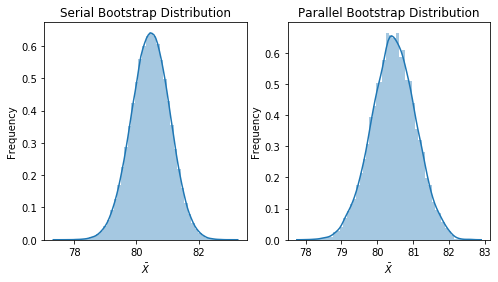

In [173]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Serial Bootstrap Distribution")
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");
sns.distplot(boot_sample_means_serial)

plt.subplot(122)
plt.title("Parallel Bootstrap Distribution")
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");
sns.distplot(boot_sample_means_parallel);

At a high level, you parallelized a slow piece of code by splitting it into many tasks, and then *reduced* the result of the individual tasks to produce a output identical to the slow code.

In addition, you specifically parallelized the `for` loop in `bootstrap_serial` to speed up bootstrap. Parallelizing loops can often speed up code which allows data scientists to process data more quickly.

This idea of parallelizing certain code and reducing the results led to a more general programming model used to reason about and implement parallel programs called MapReduce. We'll introduce and implement MapReduce in Problem 3.

## 3: Analyzing Word Frequency using MapReduce

[MapReduce](https://en.wikipedia.org/wiki/MapReduce) a computational pattern for computing aggregate statistics of large datasets. It is the core primitive in systems like MapReduce, Hadoop, and Spark.

At its core, MapReduce consists of two primitives:

- The **map** transformation takes a dataset and a function and applies the function to each data point.
- The **reduce** transformation aggregates the output of the map stage.

For example, suppose that our starting point is a collection of documents. If we wish to count the number of occurrences of each word in the document, we can first apply a "map" transformation, which turns each document into a dictionary mapping words to the number of occurrences within that document. Then we can apply the "reduce" transformation, which sums the counts for each word.

The two primitives, **map** and **reduce** are given to you below.

In [174]:
def map_parallel(function, arglist):
    """Apply a function to each element of a list in parallel.
    Args:
        function: a remote function that takes in one argument as input and outputs an ObjectID
        arglist: a list of arguments that the function will be applied to
    Returns:
        A list of ObjectIDs
    """
    if not isinstance(arglist, list):
        raise ValueError("The arglist argument must be a list.")
    
    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
            
    return [function.remote(arg) for arg in arglist]

In [175]:
def reduce_parallel(function, items):
    """Apply a function repeatedly to pairs of items until only 1 remains.
    
    Args:
        function: remote function that takes 2 items as input and returns 1 new item.
        items: a list of items which are reduced to 1 output by repeatedly calling function.
    
    Returns an ObjectID.
    
    Hint:
        1. Divide the list of items into pairs.
        2. Reduce each pair to generate a new list of items.
        3. If there was an unpaired item in (1), add it to the new list.
        The new list should be about 1/2 the size of the old list.
        4. If there is only 1 item in the new list, return that item. Otherwise, repeat steps 1-3.
        
        This algorithm is called a "tree-reduce", where the original items are the leaves
        and the final result is the root. The tree is balanced. Each non-leaf node has 2 child nodes.
        Each non-root node has 1 parent node.
    """
    if not isinstance(items, list):
        raise ValueError("The items argument must be a list.")

    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
       
    items = items.copy()   # Avoids mutating the items argument
        
    if len(items) == 1:
        return ray.put(items[0])
    
    while len(items) > 1:
        a = items.pop(0)
        b = items.pop(0)
        
        oid = function.remote(a, b)
        items.append(oid)
        
    return items[0]

Now let's analyze the frequency of words used in Shakespeare. For this question, we'll need to do the following:
1. Download the text of a few of Shakespeare's plays.
2. For each play, count the number of times each word occurs.
3. Merge the word frequencies across plays.

We've provided some helper functions that will help you with this problem below.

In [176]:
def download_text(url):
    """Returns the string of text on some webpage"""
    request = urllib.request.urlopen(url)
    return request.read().decode("utf-8")


@ray.remote
def download_text_remote(url):
    return download_text(url)

In [177]:
def count_words(text):
    """Finds the frequency of each word in a string"""
    assert isinstance(text, str), "text should be a string"
    
    frequency = dict()
    
    text = text.lower()
    matches = re.findall(r"\b\w+\b", text)
    
    for word in matches:
        count = frequency.get(word, 0)
        frequency[word] = count + 1
        
    return frequency


@ray.remote
def count_words_remote(text):
    return count_words(text)

In [178]:
def merge_dicts(a, b):
    """Merges 2 dictionaries such that the result contains keys of both a and b.
    
    If a key k is in a and in b, result[k] = a[k] + b[k].
    """
    result = a.copy()  # Don't mutate the input dictionaries
    for key, value in b.items():
        result[key] = result.get(key, 0) + value
        
    return result


@ray.remote
def merge_dicts_remote(a, b):
    return merge_dicts(a, b)

In [179]:
urls = [
    "https://www.gutenberg.org/files/1524/1524-0.txt",       # Hamlet
    "https://www.gutenberg.org/cache/epub/2264/pg2264.txt",  # Macbeth
    "https://www.gutenberg.org/cache/epub/2267/pg2267.txt",  # Othello
    "https://www.gutenberg.org/cache/epub/1777/pg1777.txt",  # Romeo and Juliet
]

### Question 3
Let's now use the MapReduce API to speed up the code in the cell below. This code computes word frequencies across several of Shakespeare's works.

In [180]:
# Parallelize the following code using the MapReduce API
start_time = time.time()

total_frequencies_serial = {}
for url in urls:
    # Download the text of the play
    text = download_text(url)
    # Count the frequency of each word in the play
    frequencies = count_words(text)
    # Add the play's word frequencies to the global word frequencies
    total_frequencies_serial = merge_dicts(total_frequencies_serial, frequencies)
    
word_freq_time_serial = time.time() - start_time
print("Word frequency count serial completed in {} seconds".format(word_freq_time_serial))

Word frequency count serial completed in 3.2262871265411377 seconds


In the cell below, speed up the code from the above cell using both `map_parallel` and `reduce_parallel`.

**HINT:** Parallelizing loops often speeds up code.

<!--
BEGIN QUESTION
name: q3
manual: false
points: 1
-->

In [181]:
start_time = time.time()

# Try to do each of these in one line!
text_ids = map_parallel(download_text_remote,urls)
frequency_ids = map_parallel(count_words_remote,ray.get(text_ids))
total_frequency_id = reduce_parallel(merge_dicts_remote,frequency_ids) #??
total_frequencies_ray = ray.get(total_frequency_id) # ??

word_freq_time_parallel = time.time() - start_time
print("Word frequency count parallel completed in {} seconds".format(word_freq_time_parallel))

Word frequency count parallel completed in 1.1825947761535645 seconds


In [182]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Let's examine some of Shakespeare's most used words. Surprised?

In [183]:
def most_used_words(freq_dict, num_words=10):
    ordered_keys = sorted(freq_dict, key=freq_dict.get, reverse=True)
    return [word for _, word in zip(range(num_words), ordered_keys)]

most_used_words(total_frequencies_ray, 10)

['the', 'and', 'to', 'i', 'of', 'a', 'you', 'my', 'that', 'in']

# Now you have completed the lab!

## Submission

Congrats! You are finished with this assignment. Please don't forget to submit by Tuesday at 11:59 pm!
Project #2 is also due tonight. 

## Optional: Ray Actors
So far, we have explored Ray's *remote functions*. The tasks generated by invoking remote functions are stateless in the sense that they are intended to map inputs to outputs without side effects. But suppose we want state to be shared and mutated by multiple tasks. In this case, we can use [Ray's *actors*](https://ray.readthedocs.io/en/latest/actors.html) to encapsulate mutable state.

*Optional:* Take a look at one interesting example of how to implement [distributed training with a parameter server using Ray actors](https://ray-project.github.io/2018/07/15/parameter-server-in-fifteen-lines.html). 

To create an actor, we decorate a Python class with the `@ray.remote` decorator.

In [187]:
@ray.remote
class Counter(object):
    def __init__(self):
        self.value = 0
    
    def increment(self):
        self.value += 1
    
    def get_value(self):
        return self.value

We can create an actor instance by invoking `.remote()` on the actor class. This starts a new actor process, which holds a copy of the `Counter` object.

In [188]:
c = Counter.remote()

We can run tasks on the actor process by invoking the actor's methods. These methods can mutate the actor's internal state (in this case, the field `self.value`). The actor executes tasks serially.

In [189]:
x1_id = c.increment.remote()
print("The actor's value is {}.".format(ray.get(c.get_value.remote())))

x2_id = c.increment.remote()
print("The actor's value is {}.".format(ray.get(c.get_value.remote())))

The actor's value is 1.
The actor's value is 2.


Suppose we want multiple tasks, actors, or processes to invoke methods on a single actor. In this case, we can pass *actor handles* around between tasks. In the example below, we pass a handle to the counter actor to a handful of tasks executing in parallel.

In [190]:
@ray.remote
def increment_counter(c):
    for _ in range(10):
        x_id = c.increment.remote()

    # Wait for the last increment call to complete before returning.
    ray.get(x_id)


initial_value = ray.get(c.get_value.remote())

# Start 4 tasks that run in parallel and all increment the counter.
increment_results = [increment_counter.remote(c) for _ in range(4)]

# Wait for all tasks to finish
ray.get(increment_results)

new_value = ray.get(c.get_value.remote())

print("The actor's value was {} and now it is {}.".format(initial_value, new_value))
assert new_value - initial_value == 4 * 10

The actor's value was 2 and now it is 42.


### Optional Question
This question will take a different approach to solving the word-count problem from Question 3.

Instead of launching four tasks that compute word counts and then aggregating the results on the "driver" process that issued the tasks, we are going to create a separate `ResultAggregator` actor for doing the aggregation. We will start four tasks that each compute frequencies for a given URL and then push those frequencies to the aggregator. The main "driver" process will then fetch the aggregated results from the aggregator.

The code below implements a serial version of this.

In [55]:
class ResultAggregator:
    """Aggregates word frequencies"""
    def __init__(self):
        self.total_frequencies = {}
    
    def add_frequencies(self, frequencies):
        """Adds a new dictionary mapping words to word frequencies to the overall word frequencies"""
        self.total_frequencies = merge_dicts(self.total_frequencies, frequencies)
    
    def get_frequencies(self):
        """Returns a dictionary mapping each word to its frequency"""
        return self.total_frequencies


def add_results(url, result_aggregator):
    """Downloads text from the url, counts the word frequencies, and adds the result to result_aggregator"""
    # Download the text of the play
    text = download_text(url)
    # Count the frequency of each word in the play
    frequencies = count_words(text)
    # Add the results to the aggregator
    done = result_aggregator.add_frequencies(frequencies)

In [56]:
result_aggregator = ResultAggregator()

start_time = time.time()

get_and_add_frequencies = [add_results(url, result_aggregator) for url in urls]

# Get the results
total_frequencies = result_aggregator.get_frequencies()

end_time = time.time()
print("Counting the words took {} seconds.".format(end_time - start_time))

serial_words = most_used_words(total_frequencies, 10)

### Optional Question A

Now implement a parallel version in which `ResultAggregator` is an actor, and `add_results` is a remote function.

In [57]:
@ray.remote 
class ResultAggregator(object):
    """Aggregates word frequencies"""
    def __init__(self):
        self.total_frequencies = {}
    
    def add_frequencies(self, frequencies):
        """Adds a new dictionary mapping words to word frequencies to the overall word frequencies"""
        self.total_frequencies = merge_dicts(self.total_frequencies, frequencies)
    
    def get_frequencies(self):
        """Returns a dictionary mapping each word to its frequency"""
        return self.total_frequencies

@ray.remote
def add_results(url, result_aggregator):
    """Downloads text from the url, counts the word frequencies, and adds the result to result_aggregator"""
    # Write your solution below
    text = ...
    frequencies = ...
    done = ...

### Optional Question B

Now use your modified `ResultAggregator` and `add_results` created above to count word frequencies. See the code cell directly above Question A for reference.

In [60]:
start_time = time.time()

# Create an instance of a ResultAggregator actor
result_aggregator = ... # Write your solution here 

# Call the add_results remote function on each URL
get_and_add_frequencies = ... # Write your solution here 

# Wait for all add_results remote functions to complete
ray.get(get_and_add_frequencies)

# Get the results from the actor
total_frequencies = ... # Write your solution here 

end_time = time.time()
print("Counting the words took {} seconds.".format(end_time - start_time))

parallel_words = most_used_words(total_frequencies, 10)

## Other Links

You've seen above how Ray makes it easy to implement a system like MapReduce as a library on top of Ray. A handful of libraries have been implemented on top of Ray. You may be interested in taking a look at the following:
- [*Tune*: Distributed hyperparameter search](https://ray.readthedocs.io/en/latest/tune.html)
([github](https://github.com/ray-project/ray/tree/master/python/ray/tune))
- [*RLlib*: Scalable reinforcement learning](https://ray.readthedocs.io/en/latest/rllib.html)
([github](https://github.com/ray-project/ray/tree/master/python/ray/rllib))
- [*Modin*: Speeding up Pandas](http://modin.org/)
([github](https://github.com/modin-project/modin))

Ray, Tune, RLlib, and Modin are research projects in UC Berkeley's RISElab. If you're interested in contributing, take a look at the project's codebase on Github!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [186]:
# Save your notebook first, then run this cell to submit.
ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab12.ipynb'.


ERROR  | auth.py:91 | {'error': 'invalid_grant'}


Performing authentication
Please enter your bCourses email.
bCourses email: dizhen@berkeley.edu

Copy the following URL and open it in a web browser. To copy,
highlight the URL, right-click, and select "Copy".

https://okpy.org/client/login/

After logging in, copy the code from the web page, paste it below,
and press Enter. To paste, right-click and select "Paste".

Paste your code here: IMF4kqhwZau2vfOQwvnQH6zDRFFJup
Successfully logged in as dizhen@berkeley.edu
Submit... 100% complete
Submission successful for user: dizhen@berkeley.edu
URL: https://okpy.org/cal/data100/su19/lab12/submissions/Jypg1y

